## 📥 Imports and Setup

In [ ]:
import os
import shutil
import random
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

## 🧹 Preparing and Labeling the Dataset

In [1]:
input_root = "/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs"
output_root = "/kaggle/working/DogsVsAiDogs_Prepared"

splits = ['Train', 'Valid', 'Test']
subdirs = ['images', 'labels']

for split in ['train', 'valid', 'test']:
    for sub in subdirs:
        os.makedirs(os.path.join(output_root, split, sub), exist_ok=True)
def get_label_from_filename(name):
    if name.lower().startswith("real_"):
        return 0
    elif name.lower().startswith("ai_"):
        return 1
    else:
        return 0 if name.startswith("n") else 1  

def process_and_copy_images(src_dir, dst_split):
    img_dir = os.path.join(input_root, src_dir, "Images")
    label_dir = os.path.join(input_root, src_dir, "Labels")
    dst_img_dir = os.path.join(output_root, dst_split, "images")
    dst_lbl_dir = os.path.join(output_root, dst_split, "labels")
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))]
    for idx, img_name in enumerate(sorted(image_files)):
        label = get_label_from_filename(img_name)
        prefix = "real" if label == 0 else "ai"
        new_name = f"{prefix}_{idx:05d}.jpg"
        image = Image.open(os.path.join(img_dir, img_name)).convert("RGB")
        image.save(os.path.join(dst_img_dir, new_name), "JPEG")
        label_name = new_name.replace(".jpg", ".txt")
        with open(os.path.join(dst_lbl_dir, label_name), "w") as f:
            f.write(str(label))

    print(f"✅ Processed {len(image_files)} images for split: {dst_split}")

process_and_copy_images("Train", "train")
process_and_copy_images("Valid", "valid")
process_and_copy_images("Test", "test")
print("\n🎉 All done! Dataset is cleaned, labeled, and organized in /kaggle/working/DogsVsAiDogs_Prepared/")


✅ Processed 18605 images for split: train
✅ Processed 5317 images for split: valid
✅ Processed 2658 images for split: test

🎉 All done! Dataset is cleaned, labeled, and organized in /kaggle/working/DogsVsAiDogs_Prepared/


## 📊 Visualizing Dataset Distribution

This section analyzes how the dataset is split across the training, validation, and test sets.

- Counts the number of images in each subset
- Displays a pie chart showing the percentage distribution

Understanding this distribution is important to verify class balance and ensure that each subset contains enough data for effective model development and evaluation.



📊 Image counts per split:
- Train: 18605 images
- Valid: 5317 images
- Test: 2658 images


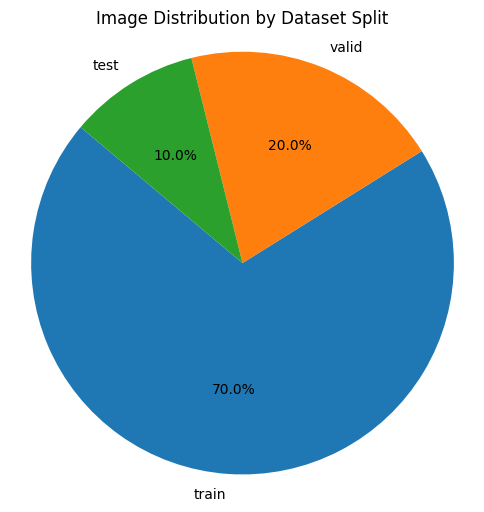

In [2]:
base_dir = "/kaggle/working/DogsVsAiDogs_Prepared"
image_counts = {}

# Count images in each split
for split in splits:
    split_dir = os.path.join(base_dir, split, "images")
    count = len([f for f in os.listdir(split_dir) if f.lower().endswith('.jpg')])
    image_counts[split] = count

print("📊 Image counts per split:")
for split, count in image_counts.items():
    print(f"- {split.capitalize()}: {count} images")
plt.figure(figsize=(6,6))
plt.pie(image_counts.values(), labels=image_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Image Distribution by Dataset Split")
plt.axis('equal')
plt.show()


## 🖼️ Visual Comparison: Real vs AI-Generated Dog Images

To better understand the dataset, a side-by-side visual comparison is displayed using six example images:

- The top row shows three real dog images
- The bottom row shows three AI-generated dog images


✅ Real images: ['real_04200.jpg', 'real_04201.jpg', 'real_04202.jpg']
✅ AI images: ['ai_00000.jpg', 'ai_00001.jpg', 'ai_00002.jpg']


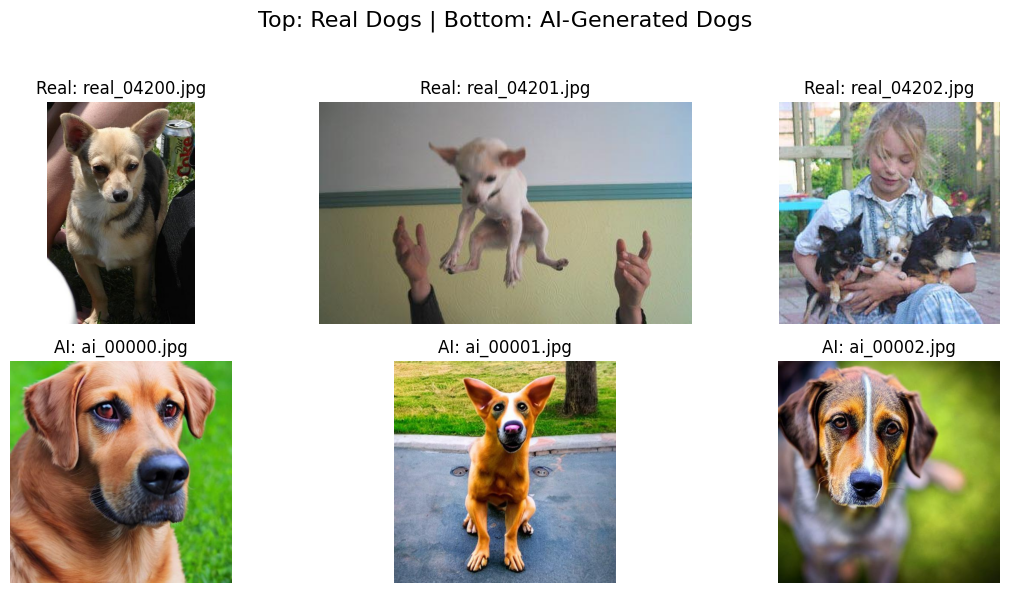

In [3]:
dataset_path = "/kaggle/working/DogsVsAiDogs_Prepared/train"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

def read_label(txt_path):
    try:
        with open(txt_path, "r") as f:
            return int(f.read().strip())
    except:
        return None

real_images, ai_images = [], []

for img_name in sorted(os.listdir(image_dir)):
    if not img_name.endswith(".jpg"):
        continue
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))
    label = read_label(label_path)
    if label == 0 and len(real_images) < 3:
        real_images.append((img_name, os.path.join(image_dir, img_name)))
    elif label == 1 and len(ai_images) < 3:
        ai_images.append((img_name, os.path.join(image_dir, img_name)))
    if len(real_images) == 3 and len(ai_images) == 3:
        break

print("✅ Real images:", [name for name, _ in real_images])
print("✅ AI images:", [name for name, _ in ai_images])

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle("Top: Real Dogs | Bottom: AI-Generated Dogs", fontsize=16)

for i, (name, img_path) in enumerate(real_images):
    try:
        img = Image.open(img_path).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Real: {name}")
        axes[0, i].axis('off')
    except Exception as e:
        print(f"⚠️ Could not open {name}: {e}")
        axes[0, i].text(0.5, 0.5, "Error loading image", ha='center')

for i, (name, img_path) in enumerate(ai_images):
    try:
        img = Image.open(img_path).convert("RGB")
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"AI: {name}")
        axes[1, i].axis('off')
    except Exception as e:
        print(f"⚠️ Could not open {name}: {e}")
        axes[1, i].text(0.5, 0.5, "Error loading image", ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 📐 Analyzing Image Dimensions

This section collects the width and height of all images in the training set.

The goal is to identify whether the dataset contains images with varying dimensions, which could impact training unless standardized.


In [4]:
dims = []
for img_name in os.listdir(image_dir):
    if img_name.endswith(".jpg"):
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as img:
                dims.append(img.size)  # (width, height)
        except:
            pass

print("🖼️ Most common image sizes:", Counter(dims).most_common(5))

🖼️ Most common image sizes: [((512, 512), 4200), ((500, 375), 3749), ((500, 333), 1426), ((375, 500), 881), ((333, 500), 476)]


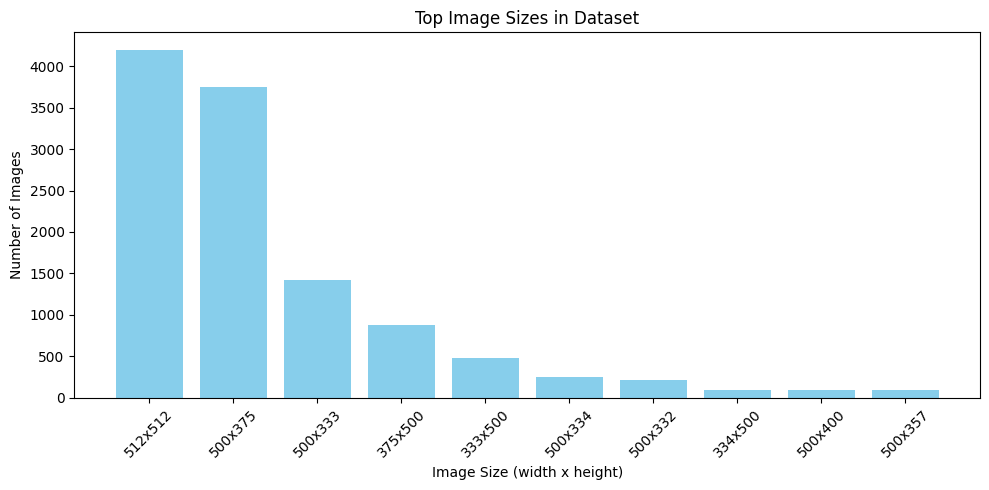

In [7]:
dims_counter = Counter(dims)
dim_labels = [f"{w}x{h}" for (w, h) in dims_counter.keys()]
dim_counts = list(dims_counter.values())

top_n = 10
top_dims = sorted(zip(dim_labels, dim_counts), key=lambda x: x[1], reverse=True)[:top_n]
labels, counts = zip(*top_dims)

plt.figure(figsize=(10,5))
plt.bar(labels, counts, color='skyblue')
plt.title("Top Image Sizes in Dataset")
plt.xlabel("Image Size (width x height)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📏 Resizing All Images to a Fixed Resolution

Neural networks require all input images to have the same size. In this step, all images in the training, validation, and test sets are resized to a fixed resolution of `224x224` pixels.

The following actions are performed:

- Resize each `.jpg` image to the target size
- Save the resized images in a new directory structure
- Copy the corresponding `.txt` label files without modification

The result is a clean and standardized dataset located in `DogsVsAiDogs_Resized/`, ready for model training.


In [8]:
input_base = "/kaggle/working/DogsVsAiDogs_Prepared"
output_base = "/kaggle/working/DogsVsAiDogs_Resized"

target_size = (224, 224)

splits = ["train", "valid", "test"]

for split in splits:
    src_img_dir = os.path.join(input_base, split, "images")
    src_lbl_dir = os.path.join(input_base, split, "labels")

    dst_img_dir = os.path.join(output_base, split, "images")
    dst_lbl_dir = os.path.join(output_base, split, "labels")

    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_lbl_dir, exist_ok=True)

    print(f"\n🔄 Processing split: {split}")

    for img_name in os.listdir(src_img_dir):
        if img_name.endswith(".jpg"):
            src_img_path = os.path.join(src_img_dir, img_name)
            dst_img_path = os.path.join(dst_img_dir, img_name)
            try:
                img = Image.open(src_img_path).convert("RGB")
                img = img.resize(target_size)
                img.save(dst_img_path, "JPEG")
            except Exception as e:
                print(f"❌ Could not resize {img_name}: {e}")
                continue

            label_name = img_name.replace(".jpg", ".txt")
            src_lbl_path = os.path.join(src_lbl_dir, label_name)
            dst_lbl_path = os.path.join(dst_lbl_dir, label_name)

            if os.path.exists(src_lbl_path):
                shutil.copy(src_lbl_path, dst_lbl_path)

    print(f"✅ Finished: {split}")

print("\n🎉 All images resized and label files copied to DogsVsAiDogs_Resized/")


🔄 Processing split: train
✅ Finished: train

🔄 Processing split: valid
✅ Finished: valid

🔄 Processing split: test
✅ Finished: test

🎉 All images resized and label files copied to DogsVsAiDogs_Resized/


In [9]:
resized_image_dir = "/kaggle/working/DogsVsAiDogs_Resized/train/images"

dims = []
for img_name in os.listdir(resized_image_dir):
    if img_name.endswith(".jpg"):
        img_path = os.path.join(resized_image_dir, img_name)
        try:
            with Image.open(img_path) as img:
                dims.append(img.size)  # (width, height)
        except:
            pass
print("🖼️ Most common image sizes (after resizing):", Counter(dims).most_common(5))


🖼️ Most common image sizes (after resizing): [((224, 224), 18605)]


## 🐶 Creating a Custom PyTorch Dataset

To efficiently load and preprocess the image-label pairs, a custom PyTorch `Dataset` class is defined.

This class:

- Loads image paths and their corresponding label files
- Applies optional transformations (e.g., normalization)
- Returns image–label pairs ready for training

Using a custom dataset allows full control over how data is read and structured, which is essential for supervised learning tasks like binary classification.

In [11]:
class DogClassifierDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        image = Image.open(img_path).convert("RGB")
        with open(label_path, "r") as f:
            label = int(f.read().strip())

        if self.transform:
            image = self.transform(image)

        return image, label


## 🧾 Data Preprocessing and Loading

To prepare the images for training, a series of preprocessing steps and data loaders are defined:

- Images are converted to PyTorch tensors
- Pixel values are normalized to the range [-1, 1] using `transforms.Normalize`



In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

base_path = "/kaggle/working/DogsVsAiDogs_Resized"
batch_size = 32


train_dataset = DogClassifierDataset(
    os.path.join(base_path, "train/images"),
    os.path.join(base_path, "train/labels"),
    transform
)
valid_dataset = DogClassifierDataset(
    os.path.join(base_path, "valid/images"),
    os.path.join(base_path, "valid/labels"),
    transform
)
test_dataset = DogClassifierDataset(
    os.path.join(base_path, "test/images"),
    os.path.join(base_path, "test/labels"),
    transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 🧠 Model Architecture and Optimization Setup

The model used for this binary classification task is a pre-trained **ResNet18**, a widely used convolutional neural network architecture.

Key configurations:

- The final fully connected layer is modified to output **2 classes**: real vs AI-generated
- The model is moved to GPU if available (`cuda`) or defaults to CPU
- **CrossEntropyLoss** is used as the loss function for classification
- The **Adam optimizer** is selected with a learning rate of `0.001` for stable and adaptive training


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # binary classification
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


## 🔁 Training Loop with Validation Monitoring

The model is trained for a defined number of epochs using the training set. After each epoch:

- The training loss is calculated and accumulated
- The model is evaluated on the validation set
- Validation accuracy is computed and printed
- The best-performing model (based on validation accuracy) is saved in memory


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 8
best_val_acc = 0.0
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total * 100

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

📚 Epoch 1/5 | Train Loss: 22.7849 | Val Accuracy: 97.82%
📚 Epoch 2/5 | Train Loss: 25.3293 | Val Accuracy: 98.06%
📚 Epoch 3/5 | Train Loss: 18.3379 | Val Accuracy: 95.96%
📚 Epoch 4/5 | Train Loss: 16.3224 | Val Accuracy: 98.33%
📚 Epoch 5/5 | Train Loss: 12.7585 | Val Accuracy: 98.50%


In [18]:
# Save best model
#torch.save(best_model_state, "/kaggle/working/best_model.pt")
print(f"✅ Best model saved with val accuracy: {best_val_acc:.2f}%")


✅ Best model saved with val accuracy: 98.50%


## 🙏 Thank You for Reading!

This notebook demonstrated how to prepare a custom image dataset and train a binary image classifier to distinguish between real and AI-generated dog images using PyTorch and a pre-trained ResNet18 model.

If you found this notebook helpful, insightful, or well-structured:

👉 **Please consider giving it an upvote** — it helps others discover useful content too!  
💬 Feedback, questions, or suggestions for improvement are more than welcome in the comments.

Thanks again and happy coding! 🐶⚡
